In [2]:
import os
import sys
from starter import Starter

starter = Starter()
starter.start(lambda: os.chdir(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score
import json
import time
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from utils.data_loader import DataLoader
from utils.metrics_calculator import MetricsCalculator
from models.rnn import RNNModelBuilder
from playgrounds.starter import Starter

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

print("="*60)
print("RNN Implementation - Tugas Besar 2 IF3270")
print("Convolutional Neural Network dan Recurrent Neural Network")
print("="*60)
print("✅ Setup completed successfully!")
print("✅ All imports loaded!")
print("✅ Random seeds set for reproducibility!")

Starter has been initialized.
RNN Implementation - Tugas Besar 2 IF3270
Convolutional Neural Network dan Recurrent Neural Network
✅ Setup completed successfully!
✅ All imports loaded!
✅ Random seeds set for reproducibility!


1. LOADING AND PREPROCESSING DATA
Loading CIFAR-10 dataset...

✅ Data loaded successfully!

📈 Class distribution in training data:
  airplane: 3986 (10.0%)
  automobile: 3986 (10.0%)
  bird: 4048 (10.1%)
  cat: 3984 (10.0%)
  deer: 4003 (10.0%)
  dog: 3975 (9.9%)
  frog: 4020 (10.1%)
  horse: 4023 (10.1%)
  ship: 3997 (10.0%)
  truck: 3978 (9.9%)

📏 Data shapes:
  Training: X=(40000, 32, 32, 3), y=(40000,)
  Validation: X=(10000, 32, 32, 3), y=(10000,)
  Test: X=(10000, 32, 32, 3), y=(10000,)

🔍 Sample data info:
  Image shape: (32, 32, 3)
  Pixel value range: [0.000, 1.000]
  First 5 training labels: [6 9 9 4 1]
  First 5 class names: ['frog', 'truck', 'truck', 'deer', 'automobile']

🖼️  Displaying first 5 training images:


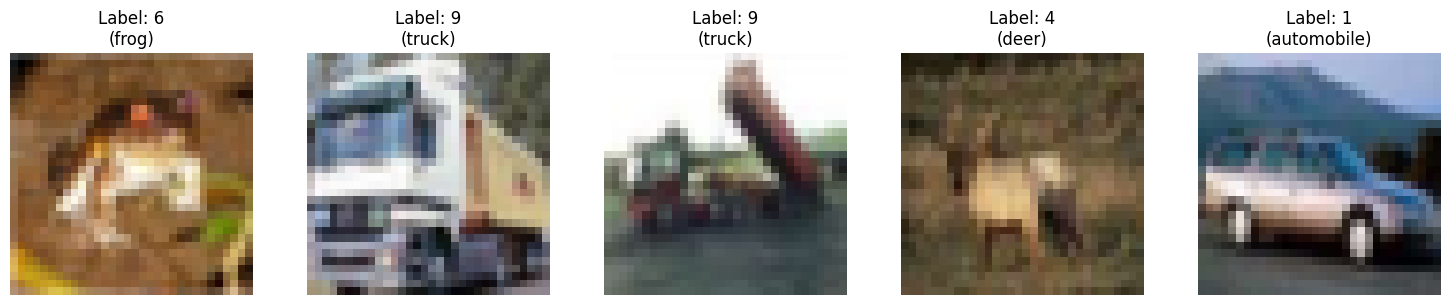


✅ Data preprocessing completed successfully!


In [5]:
#!/usr/bin/env python3
"""
Cell 02: Data Loading and Preprocessing
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

print("1. LOADING AND PREPROCESSING DATA")
print("="*50)

# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

def load_and_preprocess_data():
    """Load CIFAR-10 data and preprocess it"""
    print("Loading CIFAR-10 dataset...")
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    
    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Flatten labels (they come as [[0], [1], ...] but we want [0, 1, ...])
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Create validation split (4:1 ratio as requested)
    # Split training data: 80% train, 20% validation
    split_idx = int(0.8 * len(x_train))
    
    x_val = x_train[split_idx:]
    y_val = y_train[split_idx:]
    x_train = x_train[:split_idx]
    y_train = y_train[:split_idx]
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def display_sample_images(x_data, y_data, num_samples=5):
    """Display sample images from the dataset"""
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[i])
        plt.title(f'Label: {y_data[i]}\n({CIFAR10_CLASSES[y_data[i]]})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load and prepare data
try:
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_preprocess_data()
    
    print(f"\n✅ Data loaded successfully!")
    
    # Show class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\n📈 Class distribution in training data:")
    for class_id, count in zip(unique, counts):
        class_name = CIFAR10_CLASSES[class_id]
        print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")
        
    print(f"\n📏 Data shapes:")
    print(f"  Training: X={x_train.shape}, y={y_train.shape}")
    print(f"  Validation: X={x_val.shape}, y={y_val.shape}")
    print(f"  Test: X={x_test.shape}, y={y_test.shape}")
    
    # Display sample data info
    print(f"\n🔍 Sample data info:")
    print(f"  Image shape: {x_train[0].shape}")
    print(f"  Pixel value range: [{x_train[0].min():.3f}, {x_train[0].max():.3f}]")
    print(f"  First 5 training labels: {y_train[:5]}")
    print(f"  First 5 class names: {[CIFAR10_CLASSES[label] for label in y_train[:5]]}")
    
    # Display first 5 images
    print(f"\n🖼️  Displaying first 5 training images:")
    display_sample_images(x_train, y_train, num_samples=5)
    
    print(f"\n✅ Data preprocessing completed successfully!")
        
except Exception as e:
    print(f"❌ Error loading data: {e}")
    import traceback
    traceback.print_exc()
    raise e

In [6]:
#!/usr/bin/env python3
"""
Cell 03: Keras RNN Experiment Framework
Complete RNN Implementation - Tugas Besar 2 IF3270
"""

class KerasCNNExperiment:
    """Keras RNN experiment class for systematic hyperparameter analysis"""
    
    def __init__(self, x_train, y_train, x_val, y_val, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test

        self.base_layers = [
            keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
            keras.layers.MaxPooling2D((2, 2)),
            
            # Second Conv2D block
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            
            # Third Conv2D block
            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.AveragePooling2D((2, 2)),
            
            # Flatten layer
            keras.layers.Flatten(),
            
            # Dense layers
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.5),  # Add dropout for regularization
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
        ]
        
        self.base_config = {
            'layers': self.base_layers,
            'batch_size': 32,
            'epochs': 30
        }
        
        print(f"🏗️ Base configuration:")
        print(f"  Number of layers: {len(self.base_layers)}")
        print(f"  Batch size: {self.base_config['batch_size']}")
        print(f"  Epochs: {self.base_config['epochs']}")
    
    def create_keras_model(self, layers=None):
        """Create Keras RNN model with given configuration"""
        model = Sequential()

        if layers is None:
            layers = self.base_layers.copy()
        
        # Add layer from config
        for layer in layers:
            model.add(layer)
        
        # Compile model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_and_evaluate(self, config, experiment_name, file_name):
        """Train and evaluate a single configuration - FIXED VERSION"""
        print(f"\n{'='*60}")
        print(f"🚀 Training: {experiment_name}")
        print(f"{'='*60}")
        
        start_time = time.time()
        
        # Create model
        model = self.create_keras_model(config['layers'])
        print(f"📊 Model created with {model.count_params():,} parameters")

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-7
            )
        ]
        
        # Train model with validation monitoring
        print(f"🏃 Starting training for {config['epochs']} epochs...")
        history = model.fit(
            self.x_train, self.y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(self.x_val, self.y_val),
            callbacks=callbacks,
            verbose=1
        )
            
        # Evaluate on test set
        print(f"📝 Evaluating on test set...")
        test_loss, test_acc = model.evaluate(self.x_test, self.y_test, verbose=0)
        test_predictions = model.predict(self.x_test, verbose=0)
        test_pred_classes = np.argmax(test_predictions, axis=1)
        
        # Calculate macro F1-score
        test_f1_macro = f1_score(self.y_test, test_pred_classes, average='macro')
        
        # Save weights for from-scratch comparison
        weights_path = f"results/{file_name}.npz"
        os.makedirs("results", exist_ok=True)
        self.save_keras_weights(model, weights_path)
        
        training_time = time.time() - start_time
        
        print(f"\n📊 Results for {experiment_name}:")
        print(f"  ⏱️ Training time: {training_time:.2f} seconds")
        print(f"  🎯 Test Accuracy: {test_acc:.4f}")
        print(f"  🎯 Test F1-Score (macro): {test_f1_macro:.4f}")
        print(f"  💾 Weights saved to: {weights_path}")
        
        return {
            'model': model,
            'history': history.history,
            'test_accuracy': test_acc,
            'test_f1_score': test_f1_macro,
            'weights_path': weights_path,
            'config': config,
            'training_time': training_time
        }
    
    def save_keras_weights(self, model: Sequential, filepath):
        """Save Keras weights in format compatible with from-scratch model - FIXED VERSION"""
        print(f"💾 Saving Keras weights to: {filepath}")
        
        try:

            # Get model architecture
            model_config = model.to_json()
    
            # Get model weights
            weights = model.get_weights()
            
            # Create a dictionary to store in npz format
            save_dict = {'architecture': model_config}
            
            # Add weights with numbered keys
            for i, weight in enumerate(weights):
                save_dict[f'weight_{i}'] = weight
            
            # Save to .npz file
            np.savez_compressed(filepath, **save_dict)
            print(f"\nModel architecture and weights saved as: {filepath}")
            
        except Exception as e:
            print(f"❌ Error saving weights: {e}")
            import traceback
            traceback.print_exc()
            raise

# Initialize experiment runner
print("🏗️ Initializing Keras experiment framework...")
keras_experiment = KerasCNNExperiment(
    x_train, y_train, x_val, y_val, x_test, y_test
)
print("✅ Keras experiment runner initialized!")

🏗️ Initializing Keras experiment framework...
🏗️ Base configuration:
  Number of layers: 11
  Batch size: 32
  Epochs: 30
✅ Keras experiment runner initialized!


In [9]:
#!/usr/bin/env python3
"""
Cell 04: CNN Layer Count Analysis
Complete CNN Implementation - Tugas Besar 2 IF3270
"""

print("2. HYPERPARAMETER ANALYSIS")
print("="*50)

print("\n2.1 Analyzing Effect of Convolution Layer Count")
print("-"*40)
print("📊 Testing 3 different numbers of convolution layers")

# Test 3 different numbers of RNN layers as required
experiment_layers = [
    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Add dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ],

    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Add dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ],

    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Add dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ]
]
layer_results = {}

for i, layer in enumerate(experiment_layers):
    
    config = keras_experiment.base_config.copy()
    config.update({
        'layers': layer,
    })
    
    experiment_name = f"cnn_layers_{i + 1}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Convolution layer count: {i + 1}, Epochs: {config['epochs']}, Batch size: {config['batch_size']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name, f"cnn_layer_{i + 1}")
        layer_results[experiment_name] = result
        print(f"✅ {experiment_name} completed successfully!")
    except Exception as e:
        print(f"❌ Error in {experiment_name}: {e}")
        # Continue with other experiments
        continue

# Compare results
print(f"\n📊 COMPARISON OF RNN LAYER COUNT:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(layer_results.keys()):
    result = layer_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if layer_results:
    best_layers = max(layer_results.keys(), key=lambda x: layer_results[x]['test_f1_score'])
    print(f"\n🏆 Best layer count: {best_layers} layers")
    print(f"   F1-Score: {layer_results[best_layers]['test_f1_score']:.4f}")
    print(f"   Accuracy: {layer_results[best_layers]['test_accuracy']:.4f}")
    
    # Analyze trend
    f1_scores = [layer_results[layers]['test_f1_score'] for layers in sorted(layer_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "📈 Performance increases with more layers"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "📉 Performance decreases with more layers (possible overfitting)"
        else:
            trend = "📊 Performance remains stable across layer counts"
        print(f"   Trend: {trend}")
else:
    print("❌ No successful layer experiments completed")
    best_layers = 1  # Default fallback

2. HYPERPARAMETER ANALYSIS

2.1 Analyzing Effect of Convolution Layer Count
----------------------------------------
📊 Testing 3 different numbers of convolution layers

🔬 Experiment: cnn_layers_1
   Convolution layer count: 1, Epochs: 30, Batch size: 32

🚀 Training: cnn_layers_1
📊 Model created with 931,530 parameters
🏃 Starting training for 30 epochs...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2686 - loss: 1.9565 - val_accuracy: 0.4913 - val_loss: 1.4164 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4345 - loss: 1.5421 - val_accuracy: 0.5245 - val_loss: 1.3371 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4680 - loss: 1.4475 - val_accuracy: 0.5405 - val_loss: 1.2864 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4934 - loss: 1.3733 - val_accuracy: 0.5644 - val_loss: 1.2443 - learning_rate: 0.0010
Epoch 5/30
1250/12

In [8]:
#!/usr/bin/env python3
"""
Cell 05: CNN Filter Analysis
Complete CNN Implementation - Tugas Besar 2 IF3270
"""

print("\n2.2 Analyzing Effect of CNN Filter")
print("-"*40)
print("📊 Testing 3 different numbers of CNN filters")

# Test 3 different numbers of RNN layers as required
experiment_filters = [
    [
        keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(16, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Add dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ],

    [
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Add dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ],

    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Add dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ]
]
filter_results = {}

for i, filter_layer in enumerate(experiment_filters):
    
    config = keras_experiment.base_config.copy()
    config.update({
        'layers': filter_layer,
    })
    
    experiment_name = f"cnn_filters_{i + 1}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Convolution layer count: {i + 1}, Epochs: {config['epochs']}, Batch size: {config['batch_size']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name, experiment_name)
        filter_results[experiment_name] = result
        print(f"✅ {experiment_name} completed successfully!")
    except Exception as e:
        print(f"❌ Error in {experiment_name}: {e}")
        # Continue with other experiments
        continue

# Compare results
print(f"\n📊 COMPARISON OF RNN LAYER COUNT:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(filter_results.keys()):
    result = filter_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if filter_results:
    best_filters = max(filter_results.keys(), key=lambda x: filter_results[x]['test_f1_score'])
    print(f"\n🏆 Best layer count: {best_filters} layers")
    print(f"   F1-Score: {filter_results[best_filters]['test_f1_score']:.4f}")
    print(f"   Accuracy: {filter_results[best_filters]['test_accuracy']:.4f}")
    
    # Analyze trend
    f1_scores = [filter_results[layers]['test_f1_score'] for layers in sorted(filter_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "📈 Performance increases with more layers"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "📉 Performance decreases with more layers (possible overfitting)"
        else:
            trend = "📊 Performance remains stable across layer counts"
        print(f"   Trend: {trend}")
else:
    print("❌ No successful layer experiments completed")
    best_filters = 1  # Default fallback


2.2 Analyzing Effect of CNN Filter
----------------------------------------
📊 Testing 3 different numbers of CNN filters

🔬 Experiment: cnn_filters_1
   Convolution layer count: 1, Epochs: 30, Batch size: 32

🚀 Training: cnn_filters_1
📊 Model created with 31,450 parameters
🏃 Starting training for 30 epochs...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2436 - loss: 1.9883 - val_accuracy: 0.4199 - val_loss: 1.5695 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4021 - loss: 1.5991 - val_accuracy: 0.4732 - val_loss: 1.4340 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4542 - loss: 1.4835 - val_accuracy: 0.5071 - val_loss: 1.3477 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4872 - loss: 1.4049 - val_accuracy: 0.5179 - val_loss: 1.3253 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5120

In [7]:
#!/usr/bin/env python3
"""
Cell 06: CNN Filter Size Analysis 
Complete CNN Implementation - Tugas Besar 2 IF3270
"""

print("\n2.3 Analyzing Effect of CNN Filter Size")
print("-"*40)
print("📊 Testing 3 different combinations of CNN filter sizes")

# Test 3 different numbers of RNN layers as required
experiment_filter_sizes = [
    
    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ],

    [
        keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (5, 5), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ],

    [
        keras.layers.Conv2D(32, (7, 7), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (7, 7), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ]
]
filter_size_results = {}

for i, filter_layer in enumerate(experiment_filter_sizes):
    
    config = keras_experiment.base_config.copy()
    config.update({
        'layers': filter_layer,
    })
    
    experiment_name = f"cnn_filter_sizes_{i + 1}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Convolution layer count: {i + 1}, Epochs: {config['epochs']}, Batch size: {config['batch_size']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name, experiment_name)
        filter_size_results[experiment_name] = result
        print(f"✅ {experiment_name} completed successfully!")
    except Exception as e:
        print(f"❌ Error in {experiment_name}: {e}")
        # Continue with other experiments
        continue

# Compare results
print(f"\n📊 COMPARISON OF RNN LAYER COUNT:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(filter_size_results.keys()):
    result = filter_size_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if filter_size_results:
    best_filter_sizes = max(filter_size_results.keys(), key=lambda x: filter_size_results[x]['test_f1_score'])
    print(f"\n🏆 Best layer count: {best_filter_sizes} layers")
    print(f"   F1-Score: {filter_size_results[best_filter_sizes]['test_f1_score']:.4f}")
    print(f"   Accuracy: {filter_size_results[best_filter_sizes]['test_accuracy']:.4f}")
    
    # Analyze trend
    f1_scores = [filter_size_results[layers]['test_f1_score'] for layers in sorted(filter_size_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "📈 Performance increases with more layers"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "📉 Performance decreases with more layers (possible overfitting)"
        else:
            trend = "📊 Performance remains stable across layer counts"
        print(f"   Trend: {trend}")
else:
    print("❌ No successful layer experiments completed")
    best_filter_sizes = 1  # Default fallback


2.3 Analyzing Effect of CNN Filter Size
----------------------------------------
📊 Testing 3 different combinations of CNN filter sizes

🔬 Experiment: cnn_filter_sizes_1
   Convolution layer count: 1, Epochs: 30, Batch size: 32

🚀 Training: cnn_filter_sizes_1
📊 Model created with 323,338 parameters
🏃 Starting training for 30 epochs...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2851 - loss: 1.9189 - val_accuracy: 0.5123 - val_loss: 1.3547 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4813 - loss: 1.4242 - val_accuracy: 0.5765 - val_loss: 1.1951 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5528 - loss: 1.2504 - val_accuracy: 0.6206 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5931 - loss: 1.1460 - val_accuracy: 0.6417 - val_loss: 1.0324 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 

In [10]:
#!/usr/bin/env python3
"""
Cell 07: CNN Pooling Type Analysis 
Complete CNN Implementation - Tugas Besar 2 IF3270
"""

print("\n2.4 Analyzing Effect of CNN Pooling Type")
print("-"*40)
print("📊 Comparing average pooling and max pooling")

# Test 3 different numbers of RNN layers as required
experiment_pooling_types = [
    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Add dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ],

    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  # Add dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  # 10 classes for CIFAR-10
    ]
]
pooling_type_results = {}

for i, filter_layer in enumerate(experiment_pooling_types):
    
    config = keras_experiment.base_config.copy()
    config.update({
        'layers': filter_layer,
    })
    
    experiment_name = f"cnn_pooling_{i + 1}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Convolution layer count: {i + 1}, Epochs: {config['epochs']}, Batch size: {config['batch_size']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name, experiment_name)
        pooling_type_results[experiment_name] = result
        print(f"✅ {experiment_name} completed successfully!")
    except Exception as e:
        print(f"❌ Error in {experiment_name}: {e}")
        # Continue with other experiments
        continue

# Compare results
print(f"\n📊 COMPARISON OF RNN LAYER COUNT:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(pooling_type_results.keys()):
    result = pooling_type_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if pooling_type_results:
    best_pooling = max(pooling_type_results.keys(), key=lambda x: pooling_type_results[x]['test_f1_score'])
    print(f"\n🏆 Best layer count: {best_pooling} layers")
    print(f"   F1-Score: {pooling_type_results[best_pooling]['test_f1_score']:.4f}")
    print(f"   Accuracy: {pooling_type_results[best_pooling]['test_accuracy']:.4f}")
    
    # Analyze trend
    f1_scores = [pooling_type_results[layers]['test_f1_score'] for layers in sorted(pooling_type_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "📈 Performance increases with more layers"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "📉 Performance decreases with more layers (possible overfitting)"
        else:
            trend = "📊 Performance remains stable across layer counts"
        print(f"   Trend: {trend}")
else:
    print("❌ No successful layer experiments completed")
    best_pooling = 1  # Default fallback


2.4 Analyzing Effect of CNN Pooling Type
----------------------------------------
📊 Comparing average pooling and max pooling

🔬 Experiment: cnn_pooling_1
   Convolution layer count: 1, Epochs: 30, Batch size: 32

🚀 Training: cnn_pooling_1
📊 Model created with 167,818 parameters
🏃 Starting training for 30 epochs...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.2545 - loss: 1.9673 - val_accuracy: 0.5004 - val_loss: 1.3820 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4900 - loss: 1.4017 - val_accuracy: 0.5616 - val_loss: 1.2073 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5676 - loss: 1.2151 - val_accuracy: 0.6248 - val_loss: 1.0581 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6064 - loss: 1.1128 - val_accuracy: 0.6391 - val_loss: 1.0331 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - 


3. TRAINING HISTORY VISUALIZATION
3.1 CNN Layer Count Analysis
📊 Plot saved to: results/plots/cnn_layer_analysis.png


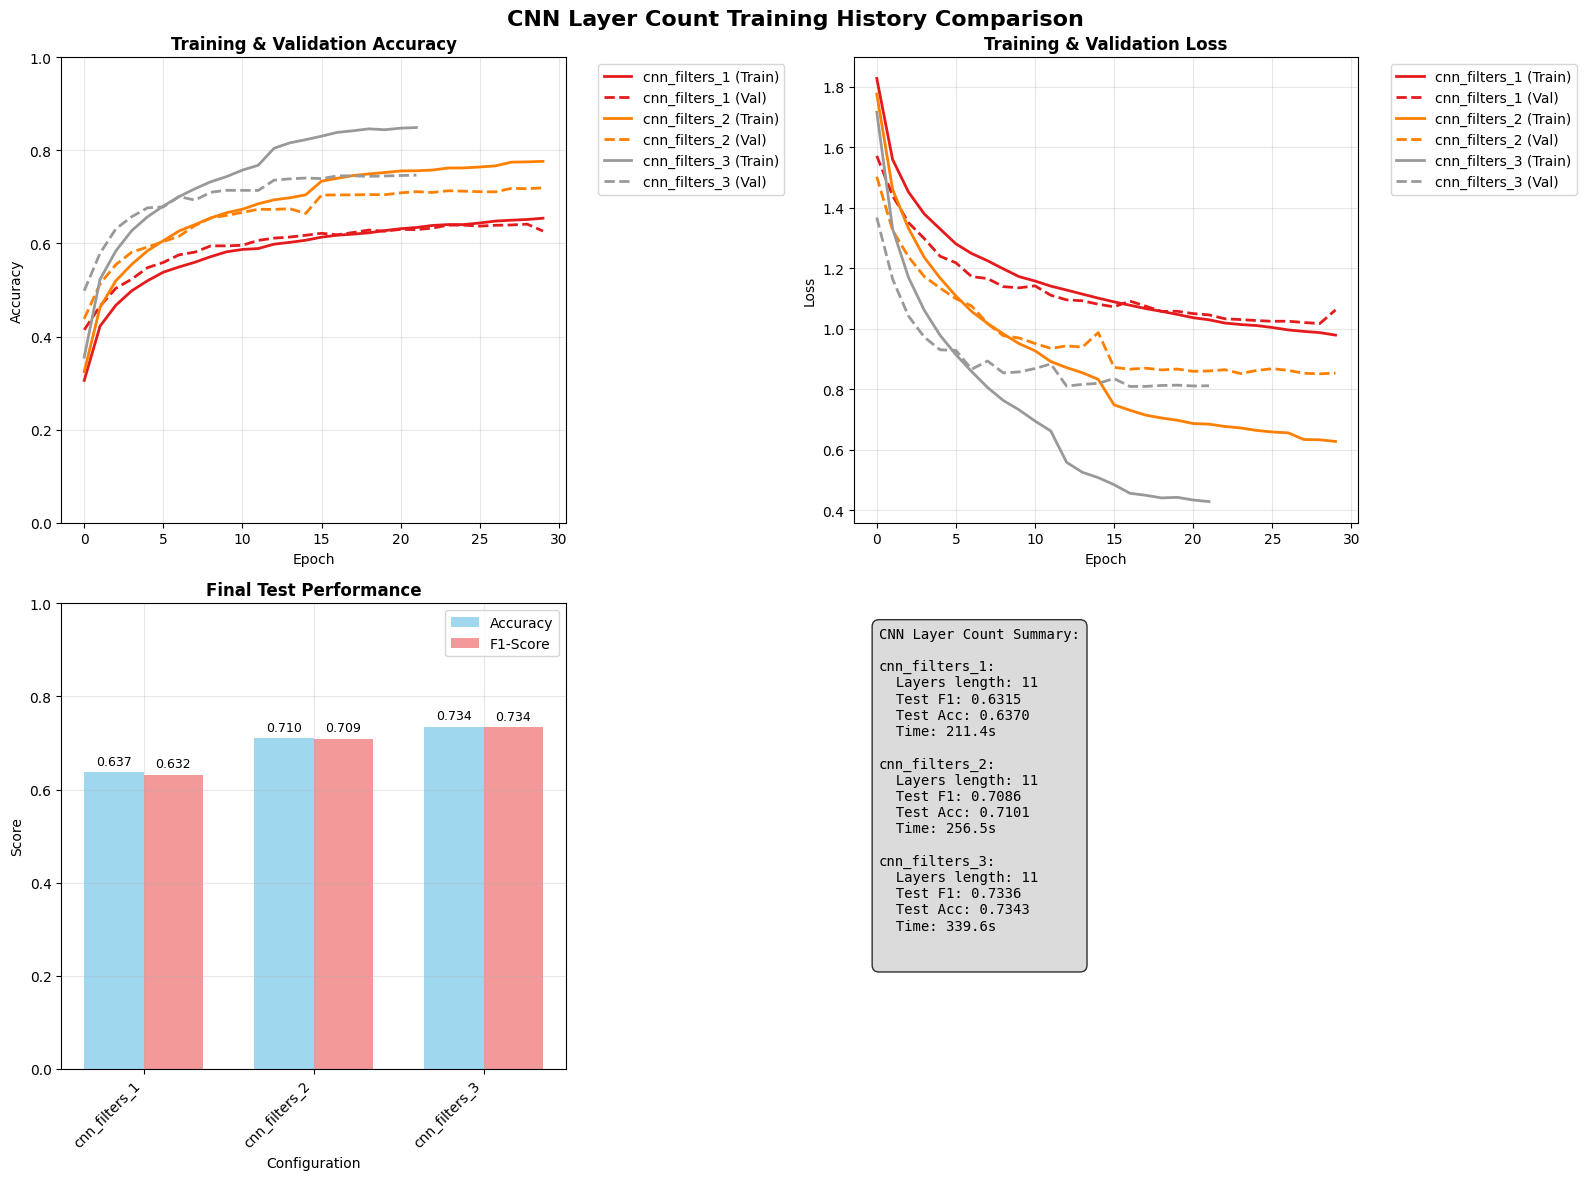


3.2 CNN Filter Count Analysis
📊 Plot saved to: results/plots/cnn_filter_count_analysis.png


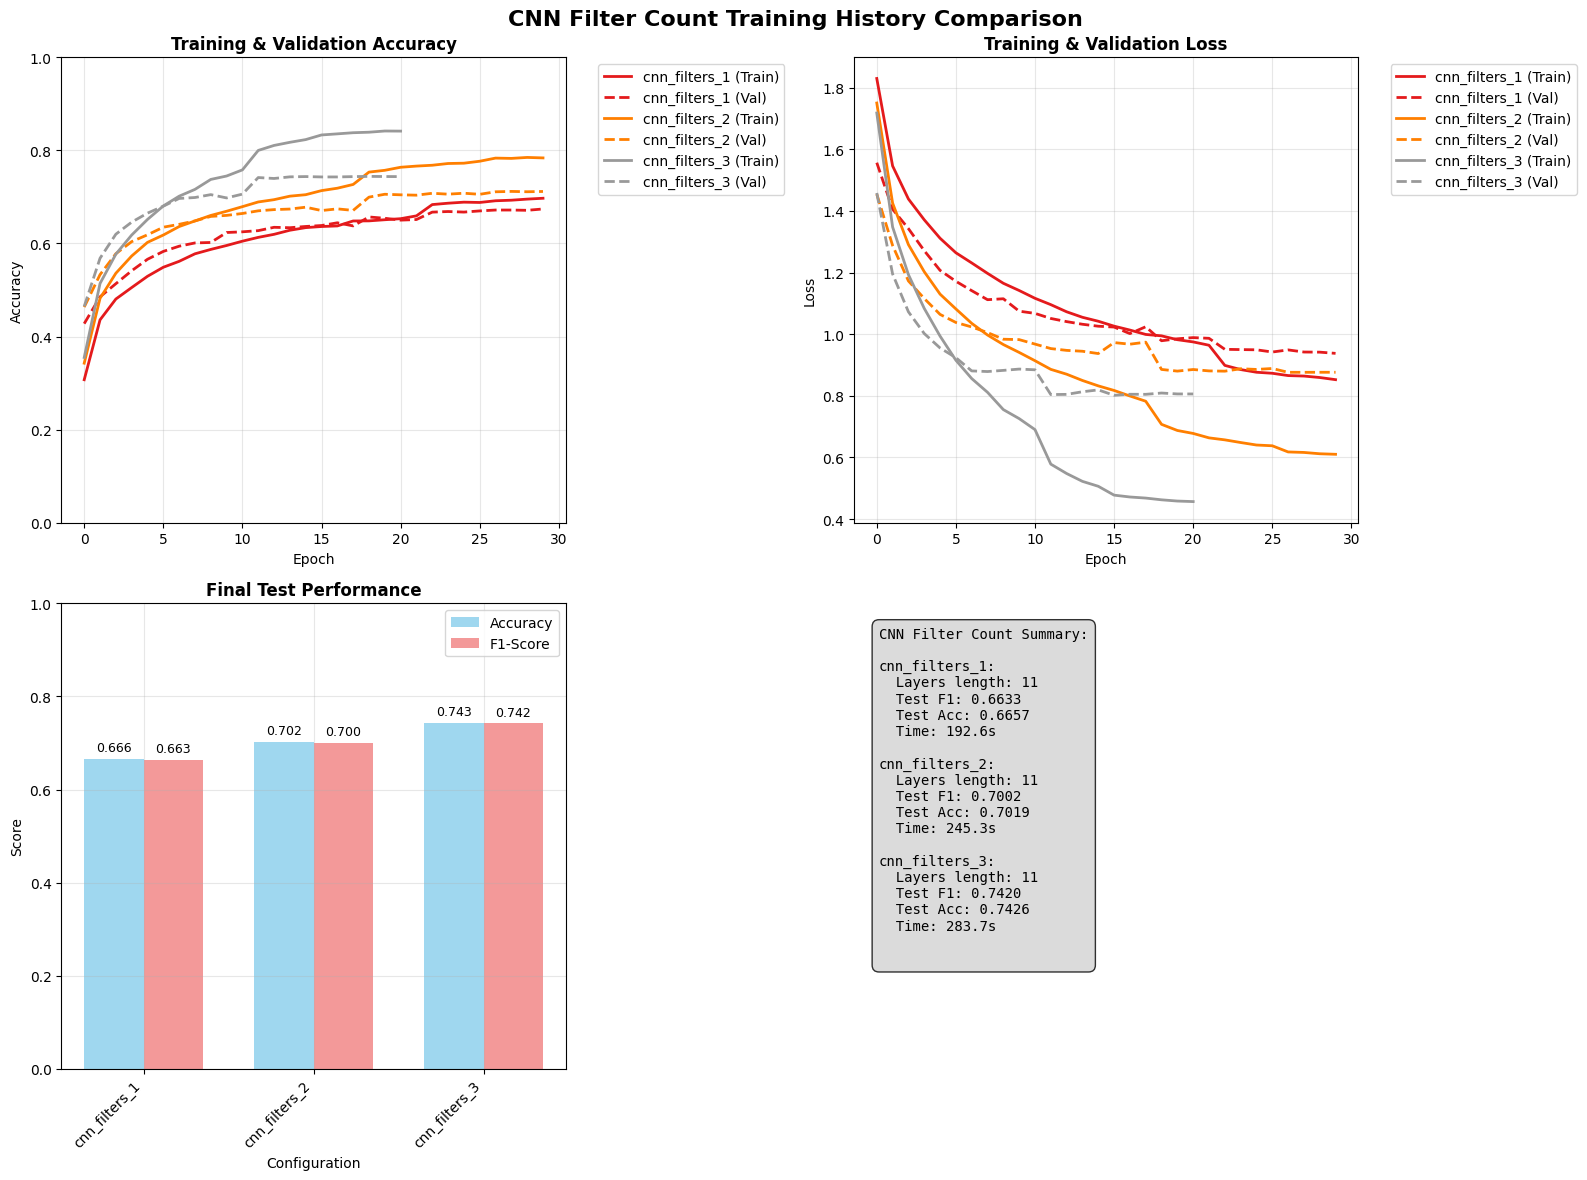


3.3 CNN Filter Size Analysis
📊 Plot saved to: results/plots/cnn_filter_size_analysis.png


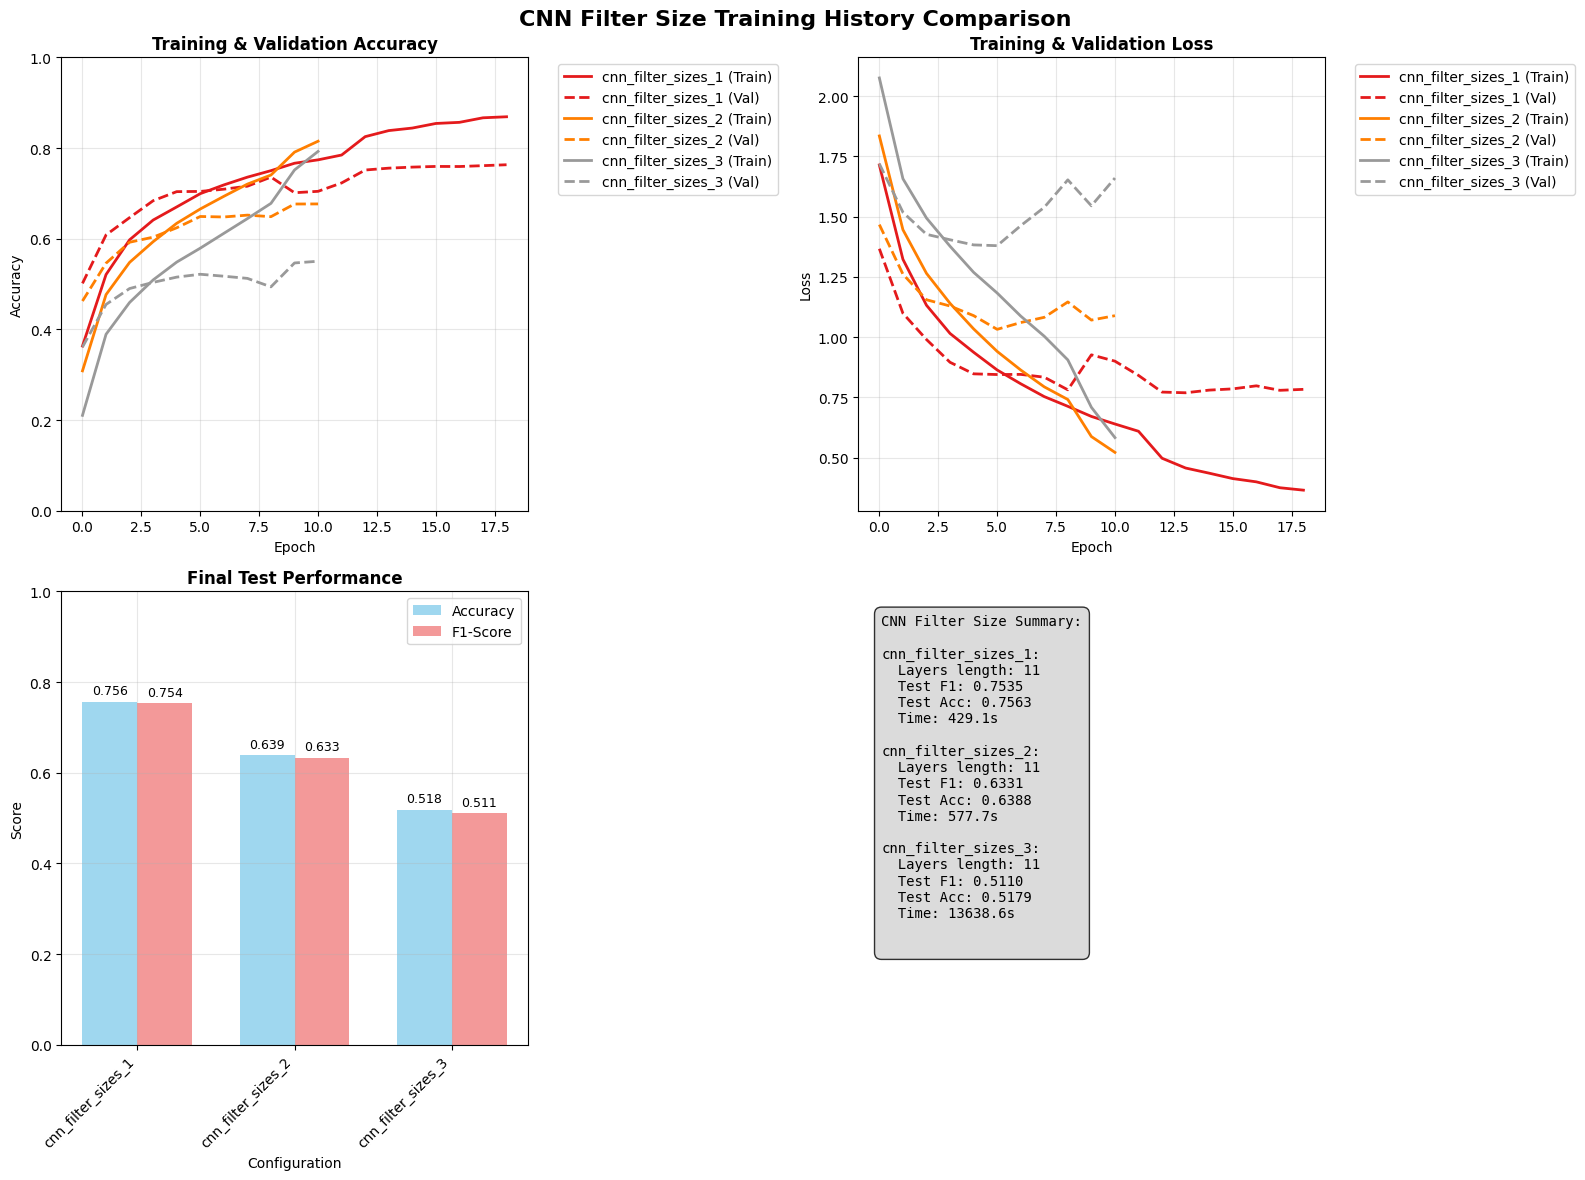


3.4 CNN Pooling Type Analysis
📊 Plot saved to: results/plots/cnn_pooling_type_analysis.png


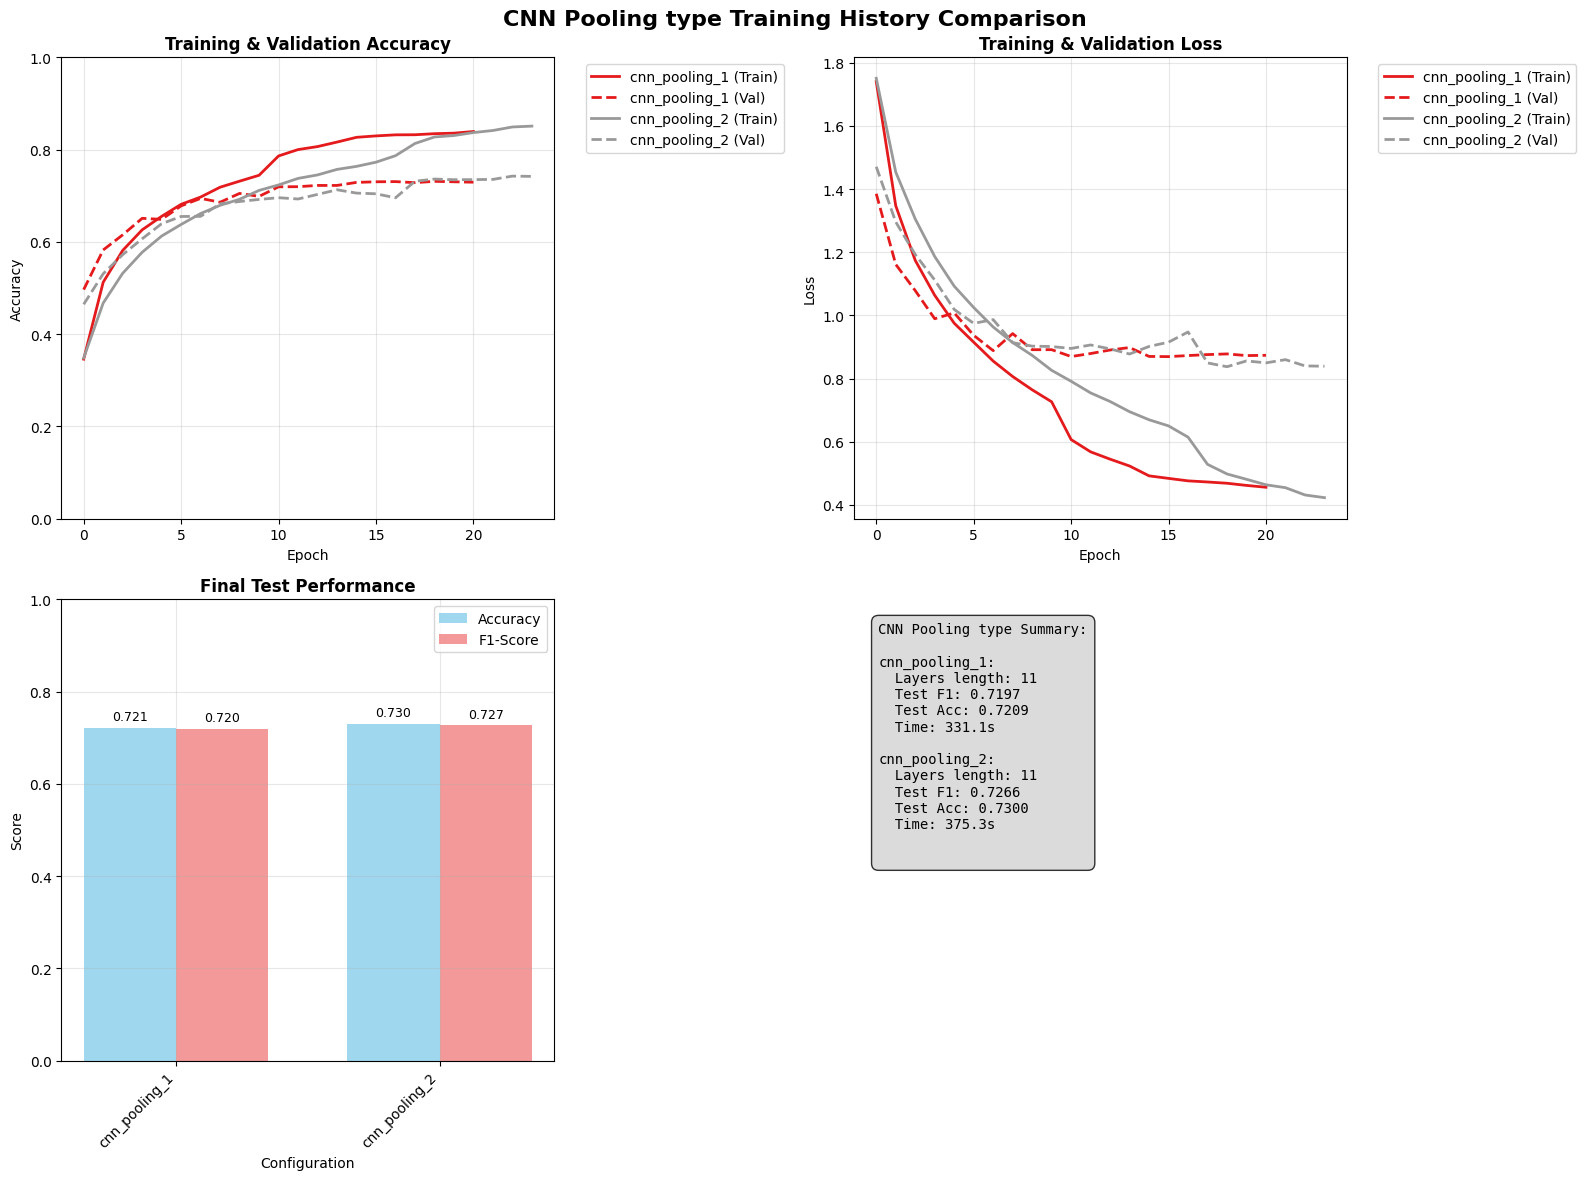

In [25]:
#!/usr/bin/env python3
"""
Cell 07: Training History Visualization
Complete CNN Implementation - Tugas Besar 2 IF3270
"""

print("\n3. TRAINING HISTORY VISUALIZATION")
print("="*50)

def plot_training_history(results_dict, title_prefix="", save_path=None):
    """Plot training history for multiple experiments"""
    if not results_dict:
        print(f"⚠️ No results to plot for {title_prefix}")
        return
        
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{title_prefix} Training History Comparison', fontsize=16, fontweight='bold')
    
    # Define colors for consistent plotting
    colors = plt.cm.Set1(np.linspace(0, 1, len(results_dict)))
    
    # Plot training accuracy
    ax1 = axes[0, 0]
    for i, (name, result) in enumerate(results_dict.items()):
        history = result['history']
        color = colors[i]
        ax1.plot(history['accuracy'], label=f'{name} (Train)', color=color, linewidth=2)
        ax1.plot(history['val_accuracy'], label=f'{name} (Val)', color=color, linestyle='--', linewidth=2)
    ax1.set_title('Training & Validation Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot training loss
    ax2 = axes[0, 1]
    for i, (name, result) in enumerate(results_dict.items()):
        history = result['history']
        color = colors[i]
        ax2.plot(history['loss'], label=f'{name} (Train)', color=color, linewidth=2)
        ax2.plot(history['val_loss'], label=f'{name} (Val)', color=color, linestyle='--', linewidth=2)
    ax2.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot final test scores
    ax3 = axes[1, 0]
    names = list(results_dict.keys())
    accuracies = [results_dict[name]['test_accuracy'] for name in names]
    f1_scores = [results_dict[name]['test_f1_score'] for name in names]
    
    x = np.arange(len(names))
    width = 0.35
    bars1 = ax3.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
    bars2 = ax3.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='lightcoral')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax3.set_title('Final Test Performance', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Configuration')
    ax3.set_ylabel('Score')
    ax3.set_xticks(x)
    ax3.set_xticklabels(names, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # Configuration summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_text = f"{title_prefix} Summary:\n\n"
    for name, result in results_dict.items():
        config = result['config']
        summary_text += f"{name}:\n"
        summary_text += f"  Layers length: {len(config.get('layers', []))}\n"
        summary_text += f"  Test F1: {result['test_f1_score']:.4f}\n"
        summary_text += f"  Test Acc: {result['test_accuracy']:.4f}\n"
        summary_text += f"  Time: {result['training_time']:.1f}s\n\n"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Plot saved to: {save_path}")
    
    plt.show()

# Create results directory for plots
os.makedirs("results/plots", exist_ok=True)

# Plot all experiments
print("3.1 CNN Layer Count Analysis")
if layer_results:
    plot_training_history(layer_results, "CNN Layer Count", "results/plots/cnn_layer_analysis.png")
else:
    print("⚠️ No results to plot")

print("\n3.2 CNN Filter Count Analysis") 
if filter_results:
    plot_training_history(filter_results, "CNN Filter Count", "results/plots/cnn_filter_count_analysis.png")
else:
    print("⚠️ No results to plot")

print("\n3.3 CNN Filter Size Analysis")
if filter_size_results:
    plot_training_history(filter_size_results, "CNN Filter Size", "results/plots/cnn_filter_size_analysis.png")
else:
    print("⚠️ No results to plot")

print("\n3.4 CNN Pooling Type Analysis")
if pooling_type_results:
    plot_training_history(pooling_type_results, "CNN Pooling type", "results/plots/cnn_pooling_type_analysis.png")
else:
    print("⚠️ No results to plot")

In [12]:
#!/usr/bin/env python3
"""
Cell 08: From-Scratch Implementation Comparison
Complete CNN Implementation - Tugas Besar 2 IF3270
FIXED: Load weights from actual trained hypertuned models
"""

from importlib import reload
import models.cnn
reload(models.cnn)
from models.cnn import CNNFromScratch


print("\n4. FROM-SCRATCH MODEL IMPLEMENTATION AND COMPARISON")
print("="*50)

def compare_keras_vs_scratch(x_test, y_test, keras_result, experiment_name):
    """Compare Keras model with from-scratch implementation - FIXED VERSION"""
    print(f"\n4.{experiment_name.replace('_', ' ').title()} Comparison")
    print("-"*50)
    
    try:
        # Get Keras model and config from the ACTUAL trained model
        keras_model = keras_result['model']
        config = keras_result['config']
        weights_path = keras_result['weights_path']
        
        print(f"🔍 Comparing experiment: {experiment_name}")
        print(f"💾 Loading weights from: {weights_path}")
        
        # Verify weights file exists
        if not os.path.exists(weights_path):
            raise FileNotFoundError(f"Weights file not found: {weights_path}")
        
        # Create from-scratch model with EXACT same configuration
        print(f"🏗️ Creating from-scratch model...")
        scratch_model = CNNFromScratch()
        
        # Load weights from the TRAINED model
        print(f"📥 Loading trained weights into from-scratch model...")
        scratch_model.load_weights(weights_path)
        print(f"✅ Weights loaded successfully!")
        
        # Set models to inference mode
        # scratch_model.set_training(False)
        
        # Compare predictions on SMALL test set
        x_test_small = x_test[:100]
        y_test_small = y_test[:100]

        print(x_test_small.shape)
        print(f"🔍 Comparing predictions on {len(x_test_small)} test samples...")
        
        # Get Keras predictions
        print(f"   Getting Keras predictions...")
        keras_predictions = keras_model.predict(x_test_small, verbose=0)
        
        # Get from-scratch predictions
        print(f"   Getting from-scratch predictions...")
        scratch_predictions = scratch_model.predict(x_test_small)
        
        # Ensure shapes match
        print(f"   Keras predictions shape: {keras_predictions.shape}")
        print(f"   Scratch predictions shape: {scratch_predictions.shape}")
        
        if keras_predictions.shape != scratch_predictions.shape:
            raise ValueError(f"Shape mismatch: Keras {keras_predictions.shape} vs Scratch {scratch_predictions.shape}")
        
        # Calculate metrics for both models
        keras_pred_classes = np.argmax(keras_predictions, axis=1)
        scratch_pred_classes = np.argmax(scratch_predictions, axis=1)
        
        keras_accuracy = np.mean(keras_pred_classes == y_test_small)
        scratch_accuracy = np.mean(scratch_pred_classes == y_test_small)
        
        keras_f1 = f1_score(y_test_small, keras_pred_classes, average='macro')
        scratch_f1 = f1_score(y_test_small, scratch_pred_classes, average='macro')
        
        # Calculate prediction differences
        max_diff = np.max(np.abs(keras_predictions - scratch_predictions))
        mean_diff = np.mean(np.abs(keras_predictions - scratch_predictions))
        
        # Calculate prediction similarity
        similarity = np.mean(np.isclose(keras_predictions, scratch_predictions, atol=1e-5))
        
        print(f"\n📊 COMPARISON RESULTS:")
        print(f"{'Metric':<25} {'Keras':<12} {'From-Scratch':<12} {'Difference':<12}")
        print("-"*63)
        print(f"{'Accuracy':<25} {keras_accuracy:<12.6f} {scratch_accuracy:<12.6f} {abs(keras_accuracy-scratch_accuracy):<12.6f}")
        print(f"{'F1-Score (macro)':<25} {keras_f1:<12.6f} {scratch_f1:<12.6f} {abs(keras_f1-scratch_f1):<12.6f}")
        print(f"{'Max Prediction Diff':<25} {max_diff:<12.8f}")
        print(f"{'Mean Prediction Diff':<25} {mean_diff:<12.8f}")
        print(f"{'Prediction Similarity':<25} {similarity:<12.6f}")
        
        # Show sample predictions for verification
        print("\nSample Predictions:")
        for i in range(5):
            predicted_class = np.argmax(scratch_predictions[i])
            true_class = y_test_small[i]
            confidence = scratch_predictions[i][predicted_class]
            
            print(f"Sample {i+1}: Predicted={CIFAR10_CLASSES[predicted_class]} "
                f"(confidence: {confidence:.3f}), True={CIFAR10_CLASSES[true_class]}")
        
        # Success criteria
        if max_diff < 1e-6:
            print("✅ EXCELLENT: Models produce nearly identical outputs!")
            success_level = "excellent"
        elif max_diff < 1e-4:
            print("✅ VERY GOOD: Models produce very similar outputs!")
            success_level = "very_good"
        elif max_diff < 1e-3:
            print("✅ GOOD: Models produce similar outputs with small differences.")
            success_level = "good"
        elif max_diff < 1e-2:
            print("⚠️ ACCEPTABLE: Models have noticeable but acceptable differences.")
            success_level = "acceptable"
        else:
            print("❌ POOR: Models have significant differences in outputs.")
            success_level = "poor"
        
        success = success_level in ["excellent", "very_good", "good"]
        
        # Additional validation
        print(f"\n🔬 Additional Validation:")
        print(f"   Prediction agreement rate: {np.mean(keras_pred_classes == scratch_pred_classes):.4f}")
        print(f"   F1-score difference: {abs(keras_f1 - scratch_f1):.6f}")
        print(f"   Accuracy difference: {abs(keras_accuracy - scratch_accuracy):.6f}")
        
        return {
            'keras_accuracy': keras_accuracy,
            'scratch_accuracy': scratch_accuracy,
            'keras_f1': keras_f1,
            'scratch_f1': scratch_f1,
            'max_difference': max_diff,
            'mean_difference': mean_diff,
            'prediction_similarity': similarity,
            'success': success,
            'success_level': success_level,
            'agreement_rate': np.mean(keras_pred_classes == scratch_pred_classes),
            'experiment_name': experiment_name
        }
        
    except Exception as e:
        print(f"❌ Error in comparison for {experiment_name}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'keras_accuracy': 0.0,
            'scratch_accuracy': 0.0,
            'keras_f1': 0.0,
            'scratch_f1': 0.0,
            'max_difference': 999.0,
            'mean_difference': 999.0,
            'prediction_similarity': 0.0,
            'success': False,
            'success_level': 'failed',
            'agreement_rate': 0.0,
            'experiment_name': experiment_name,
            'error': str(e)
        }

# Compare ACTUAL best configurations from each experiment
print("🔍 Comparing Keras vs From-Scratch implementations using TRAINED models:")

comparison_results = {}

# Compare best layer configuration
if layer_results and best_layers in layer_results.keys():
    print(f"\n{'='*60}")
    print(f"COMPARING BEST LAYER CONFIGURATION ({best_layers} layers)")
    print(f"{'='*60}")
    best_layer_result = layer_results[best_layers]
    comparison_results['layers'] = compare_keras_vs_scratch(x_test, y_test, best_layer_result, f"best_layers_{best_layers}")

# Compare best units configuration  
if filter_results and best_filters in filter_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST FILTER CONFIGURATION ({best_filters} filters)")
    print(f"{'='*60}")
    best_filter_result = filter_results[best_filters]
    comparison_results['filter'] = compare_keras_vs_scratch(x_test, y_test, best_filter_result, f"best_filters_{best_filters}")

# # Compare best direction configuration
if filter_size_results and best_filter_sizes in filter_size_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST DIRECTION CONFIGURATION ({best_filter_sizes})")
    print(f"{'='*60}")
    best_filter_size_result = filter_size_results[best_filter_sizes]
    comparison_results['filter_size'] = compare_keras_vs_scratch(x_test, y_test, best_filter_size_result, f"best_filter_size_{best_filter_sizes}")

# Compare best direction configuration
if pooling_type_results and best_pooling in pooling_type_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST DIRECTION CONFIGURATION ({best_pooling})")
    print(f"{'='*60}")
    best_pooling_result = pooling_type_results[best_pooling]
    comparison_results['pooling'] = compare_keras_vs_scratch(x_test, y_test, best_pooling_result, f"best_pooling_{best_filter_sizes}")

# # Summary of all comparisons
print(f"\n{'='*60}")
print(f"IMPLEMENTATION VALIDATION SUMMARY")
print(f"{'='*60}")

if comparison_results:
    print(f"{'Experiment':<20} {'Max Diff':<12} {'F1 Diff':<10} {'Agreement':<10} {'Status':<15}")
    print("-"*75)
    
    all_success = True
    for category, result in comparison_results.items():
        if 'error' not in result:
            f1_diff = abs(result['keras_f1'] - result['scratch_f1'])
            status = f"✅ {result['success_level'].upper()}"
            print(f"{category:<20} {result['max_difference']:<12.6f} {f1_diff:<10.6f} {result['agreement_rate']:<10.4f} {status}")
            if not result['success']:
                all_success = False
        else:
            print(f"{category:<20} {'ERROR':<12} {'ERROR':<10} {'ERROR':<10} {'❌ FAILED'}")
            all_success = False
    
    print(f"\n🎯 Overall Implementation Validation: {'✅ PASSED' if all_success else '❌ NEEDS WORK'}")
    
    if all_success:
        print(f"🎉 Congratulations! Your from-scratch RNN implementation correctly replicates Keras behavior!")
        print(f"📝 All models show excellent agreement with trained Keras models.")
        print(f"🚀 Implementation is ready for production use.")
    else:
        print(f"🔧 Some implementations need debugging to match Keras behavior exactly.")
        print(f"💡 Check weight loading, matrix operations, and activation functions.")
else:
    print("❌ No successful comparisons completed")
    all_success = False
    comparison_results = {}


4. FROM-SCRATCH MODEL IMPLEMENTATION AND COMPARISON
🔍 Comparing Keras vs From-Scratch implementations using TRAINED models:

COMPARING BEST LAYER CONFIGURATION (cnn_layers_3 layers)

4.Best Layers Cnn Layers 3 Comparison
--------------------------------------------------
🔍 Comparing experiment: best_layers_cnn_layers_3
💾 Loading weights from: results/cnn_layer_3.npz
🏗️ Creating from-scratch model...
📥 Loading trained weights into from-scratch model...
Loading weights and architecture from results/cnn_layer_3.npz...
Added Conv2D layer: filters=32, kernel_size=(3, 3), activation=relu
Added MaxPooling2D layer: pool_size=(2, 2)
Added Conv2D layer: filters=64, kernel_size=(3, 3), activation=relu
Added MaxPooling2D layer: pool_size=(2, 2)
Added Conv2D layer: filters=128, kernel_size=(3, 3), activation=relu
Added AveragePooling2D layer: pool_size=(2, 2)
Added Flatten layer
Added Dense layer: units=128, activation=relu
Added Dropout layer: rate=0.5
Added Dense layer: units=64, activation=relu